This is a basic tutorial using Notebook and a few functions of PrefLib.  It is an updated version of the tutorial presented at EXPLORE in 2014 (www.preflib.org/beyond2014)

It shows how to use some of the PrefLib tools within Python to generate a variety of test instances and then graph based on the average margin of victory for Borda scoring.  This is meant to demonstrate some of the power of the PrefLib utility library.

Note that this was written agains a devlopment version of the (1.5) version of the library.  You must have SciPy installed (or at the very least Numpy and MatplotLib) and they must be in your Python include directory.

In [1]:
import copy
import random
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#Standard MatPlot Magic.
%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 22}

matplotlib.rc('font', **font)

You must have installed the preflibtools libraries into your python that is being used by notebook (Python3 hopefully).  The easiest way to do this is to go to the directory where you cloned the repository and type in:
    * pip3 install -e .

This will install the package editable so that you do not need to reinstall it again if we update some of the code.  The way to check that this worked is you should now have a *.egg-info* directory present where setup.py was.

In [2]:
# Import utilities and generators.
from preflibtools import io
from preflibtools import generate_profiles

#Generate a candidate set
candidate_set = generate_profiles.gen_cand_map(5)
print("Cand. Dict.: " + str(candidate_set))

#Shuffle the Reference ranking for a Mallows Model
ref_ranking = copy.copy(list(candidate_set.keys()))
random.shuffle(ref_ranking)
print("Reference Ranking: " + str(ref_ranking))

#Generate a Mallows Mix with 1 model, selected 100% of the time, phi=0.2, and the one reference ranking above.
rmaps, rmapcounts = generate_profiles.gen_mallows(50, candidate_set, [1.0], [0.2], [ref_ranking])
io.pp_profile_toscreen(candidate_set, rmaps, rmapcounts)

Cand. Dict.: {1: 'Candidate 1', 2: 'Candidate 2', 3: 'Candidate 3', 4: 'Candidate 4', 5: 'Candidate 5'}
Reference Ranking: [1, 3, 2, 4, 5]


   n    |             Candidate             
---------------------------------------------------------------------------
   1    |            Candidate 1            
   2    |            Candidate 2            
   3    |            Candidate 3            
   4    |            Candidate 4            
   5    |            Candidate 5            
---------------------------------------------------------------------------
 Count  |              Profile              
   19   |             1,3,2,4,5             
   6    |             3,1,2,4,5             
   5    |             1,3,4,2,5             
   5    |             1,2,3,4,5             
   3    |             1,3,2,5,4             
   2    |             3,1,2,5,4             
   2    |             1,2,4,3,5             
   1    |             1,2,5,3,4             
   1    |             1,3,5,2,4 

### Using the above profile we can create and evaluate a scoring rule for the given profile.

In [3]:
#Create and Evaluate the Borda Rule. 
m = len(candidate_set)
svec = [m - i for i in range(1,len(candidate_set)+1)]
print("Scoring Vector: " + str(svec))

#Evaluate the above profile using this scoring rule.
scores = io.evaluate_scoring_rule(candidate_set, rmaps, rmapcounts, svec)
io.pp_result_toscreen(candidate_set, scores)

#Evaluate the Margin of victory. 

Scoring Vector: [4, 3, 2, 1, 0]


   n    |             Candidate             |               Score               
---------------------------------------------------------------------------
   1    |            Candidate 1            |                185                
   3    |            Candidate 3            |                147                
   2    |            Candidate 2            |                96                 
   4    |            Candidate 4            |                59                 
   5    |            Candidate 5            |                13                 


0

3 :: 78.48
4 :: 82.08
5 :: 83.09
6 :: 82.5
7 :: 82.58
8 :: 82.19


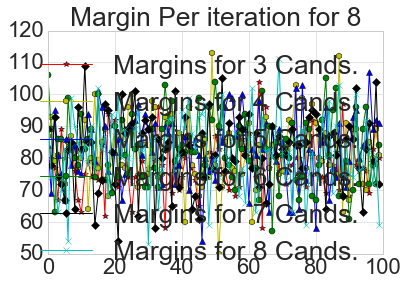

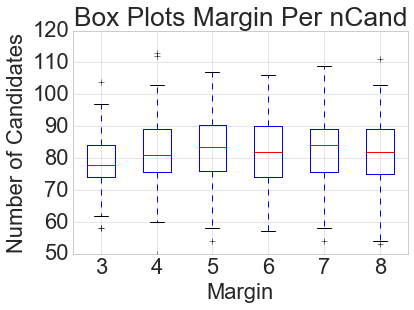

In [5]:
colors = ['r', 'y', 'b', 'g', 'k', 'c']
markers = ["*", "h", "^", "o", "D", "x"]

min_candidates = 3
max_candidates = 8

#Number of Voters
num_voters = 100

#Number of Iterations
num_iterations = 100

#Generate an instance for each number of candidates.
#Plot the average margin of victory of the winner.
margins_per_ncands = {}
for c_candidates in range(min_candidates, max_candidates+1):
    candidate_set = generate_profiles.gen_cand_map(c_candidates)

    margins = []
    for cinst in range(num_iterations):
        ref_ranking = copy.copy(list(candidate_set.keys()))
        random.shuffle(ref_ranking)
        rmaps, rmapcounts = generate_profiles.gen_mallows(num_voters, candidate_set, [1.0], [0.2], [ref_ranking])

        #Create and Evaluate the Borda Rule. 
        m = c_candidates
        svec = [m - i for i in range(1,m+1)]
        scores = io.evaluate_scoring_rule(candidate_set, rmaps, rmapcounts, svec)

        #Margin of Victory.
        totals = sorted(list(scores.values()), reverse=True)
        margins.append(totals[0] - totals[1])


    #print(margins)
    #print(float(sum(margins)) / float(num_iterations))

    '''
    #Plot a Line.
    fig, ax = plt.subplots()
    ax.plot(range(0,num_iterations), margins, color="blue", marker="+", label="Margin on Iteration")
    ax.set_title("Margin Per iteration for " + str(c_candidates))
    ax.legend()
    plt.show()


    #Plot a Histogram
    fig, ax = plt.subplots()
    #Options: bins= changes the number of bins on the histogram.
    # 		  normed= sets the histogram to be normed.
    # 		  cumulative= sets the 
    ax.hist(margins, color="blue", label="Margin on Iteration", bins=100, normed=True)
    ax.set_title("Margin Per iteration for " + str(c_candidates))
    ax.legend()
    plt.show()
    exit()
    '''
    margins_per_ncands[c_candidates] = margins

#Print all the averages..
for c_candidates in sorted(margins_per_ncands.keys()):
    print(str(c_candidates) + " :: " + str(sum(margins_per_ncands[c_candidates]) / len(margins_per_ncands[c_candidates])))

#Overlay all the plots...
fig, ax = plt.subplots()
i = 0
for c_candidates in margins_per_ncands.keys():
    ax.plot(range(0,num_iterations), margins_per_ncands[c_candidates], color=colors[i], marker=markers[i], label="Margins for " +str(c_candidates) + " Cands.")
    i += 1
ax.set_title("Margin Per iteration for " + str(c_candidates))
ax.legend()
plt.show()

#Show Boxplots for each n_cand.
fig, ax = plt.subplots()
box_plots = []
x_labels = []
for i in sorted(margins_per_ncands.keys()):
    box_plots.append(margins_per_ncands[i])
    x_labels.append(i)
ax.boxplot(box_plots)
xtickNames = plt.setp(ax, xticklabels=x_labels)
ax.set_title("Box Plots Margin Per nCand")
ax.set_ylabel("Number of Candidates")
ax.set_xlabel("Margin")
plt.show()


In [6]:
print(margins_per_ncands)
import pandas as pd
df = pd.DataFrame(margins_per_ncands)
print(df)

{3: [78, 80, 77, 67, 89, 80, 86, 85, 76, 67, 63, 75, 79, 74, 80, 73, 84, 62, 94, 90, 92, 71, 85, 89, 74, 63, 74, 75, 79, 74, 77, 77, 79, 96, 78, 58, 94, 69, 78, 70, 74, 80, 96, 77, 73, 65, 85, 80, 82, 76, 87, 83, 75, 76, 70, 77, 68, 71, 86, 83, 88, 80, 74, 104, 58, 96, 77, 84, 85, 76, 84, 72, 78, 78, 80, 80, 75, 71, 85, 92, 75, 74, 74, 69, 80, 78, 82, 70, 97, 74, 68, 86, 78, 76, 77, 76, 69, 83, 90, 80], 4: [87, 93, 79, 81, 72, 72, 85, 87, 82, 77, 80, 92, 64, 80, 100, 77, 85, 89, 68, 82, 90, 76, 78, 77, 96, 100, 83, 71, 84, 84, 75, 98, 96, 74, 75, 93, 84, 94, 76, 88, 81, 60, 96, 78, 75, 68, 71, 86, 74, 113, 78, 50, 71, 85, 88, 77, 76, 88, 75, 81, 91, 60, 70, 84, 80, 93, 77, 84, 80, 75, 76, 83, 92, 91, 103, 75, 99, 77, 92, 97, 91, 80, 79, 88, 78, 76, 75, 112, 63, 91, 67, 89, 89, 79, 72, 70, 85, 80, 89, 81], 5: [84, 69, 95, 81, 75, 67, 83, 78, 84, 76, 75, 86, 94, 89, 79, 101, 96, 90, 76, 70, 82, 86, 67, 75, 90, 90, 92, 97, 81, 94, 89, 82, 91, 71, 72, 90, 88, 91, 72, 78, 82, 87, 70, 83, 86

In [7]:
print(df.mean())

3    78.48
4    82.08
5    83.09
6    82.50
7    82.58
8    82.19
dtype: float64


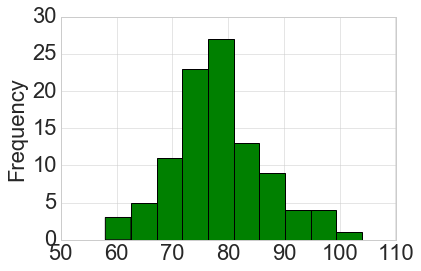

In [8]:
df.mean().plot(kind='hist')

df[3].plot(kind='hist')

In [10]:
# Try opening a file from the web..
#import urllib
import urllib.request

f = urllib.request.urlopen('http://www.preflib.org/data/election/shirt/ED-00012-00000001.soc')
c, r, counts, nvoters = io.read_election_file(f)
io.pp_profile_toscreen(c, r, counts)




   n    |             Candidate             
---------------------------------------------------------------------------
   1    |             Australia             
   2    |              Braille              
   3    |           Brush Strokes           
   4    |            Exponential            
   5    |              College              
   6    |          Graph Coloring           
   7    |                Red                
   8    |              Simple               
   9    |             Star Trek             
   10   |                TSP                
   11   |                VRP                
---------------------------------------------------------------------------
 Count  |              Profile              
   1    |      10,6,7,8,11,5,3,2,1,9,4      
   1    |      1,10,11,9,6,7,3,5,8,2,4      
   1    |      11,10,1,3,6,8,5,7,4,9,2      
   1    |      10,3,5,8,11,1,6,2,4,7,9      
   1    |      1,6,10,11,3,8,2,4,5,7,9      
   1    |      2,5,1,8,6,10,7,4,9,11

In [13]:
#Create and Evaluate the Borda Rule. 
m = len(c)
svec = [m - i for i in range(1,len(c)+1)]
print("Scoring Vector: " + str(svec))

#Evaluate the above profile using this scoring rule.
scores = io.evaluate_scoring_rule(c, r, counts, svec)
io.pp_result_toscreen(c, scores)

Scoring Vector: [21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11]


   n    |             Candidate             |               Score               
---------------------------------------------------------------------------
   10   |                TSP                |                561                
   6    |          Graph Coloring           |                550                
   1    |             Australia             |                535                
   11   |                VRP                |                509                
   3    |           Brush Strokes           |                498                
   8    |              Simple               |                494                
   2    |              Braille              |                449                
   5    |              College              |                437                
   9    |             Star Trek             |                425                
   7    |                Red                |      

0

In [15]:
# 2 Approval?
vec = [0] * len(c)
vec[0] = 1
#vec[1] = 1

#Evaluate the above profile using this scoring rule.
print("Scoring Vector: " + str(vec))
scores = io.evaluate_scoring_rule(c, r, counts, vec)
io.pp_result_toscreen(c, scores)

Scoring Vector: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


   n    |             Candidate             |               Score               
---------------------------------------------------------------------------
   10   |                TSP                |                13                 
   1    |             Australia             |                12                 
   6    |          Graph Coloring           |                10                 
   3    |           Brush Strokes           |                 8                 
   2    |              Braille              |                 5                 
   9    |             Star Trek             |                 5                 
   11   |                VRP                |                 5                 
   5    |              College              |                 1                 
   7    |                Red                |                 1                 
   4    |            Exponential            |                 

0